Original Data source
https://nihcc.app.box.com/v/ChestXray-NIHCC

Google Healthcare APIs
https://cloud.google.com/healthcare-api/docs/resources/public-datasets/nih-chest





In [516]:
!pip install kagglehub
!pip install kagglehub[pandas-datasets]
!pip install wget
!pip install keras-tuner

## Load Libraries

In [517]:
import os
import zipfile
import seaborn as sns
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import urllib.request

import tensorflow as tf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, models, Input, Model
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch


In [518]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [519]:
# Global flags
SKIP_BOUNDING_BOX = True
SKIP_DOWNLOAD = False
SKIP_UNZIP = False

RESIZED_IMAGES_ZIP_PATH = "/content/drive/MyDrive/AAI-590_Collabs"
RESIZED_IMAGES_PATH = "/content/image_resized/images_resized";

In [520]:
SKIP_DOWNLOAD = os.path.exists(RESIZED_IMAGES_ZIP_PATH)
SKIP_UNZIP = os.path.exists(RESIZED_IMAGES_PATH)

In [521]:
# print current variables
print("SKIP_DOWNLOAD: ", SKIP_DOWNLOAD)
print("SKIP_UNZIP: ", SKIP_UNZIP)

SKIP_DOWNLOAD:  True
SKIP_UNZIP:  True


## Load Dataset

In [522]:
# Set the dataset path
dataset_name = "nih-chest-xrays/data"
version = 3
# Set the path to the file you'd like to load
file_path = "Data_Entry_2017.csv"
file_path_bbox = "BBox_List_2017.csv"

gcloud_url_base = 'https://storage.googleapis.com/gcs-public-data--healthcare-nih-chest-xray/png/'

In [523]:
# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df_box_list = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  dataset_name,
  file_path_bbox
)

<ipython-input-523-1e51267dc0e1>:2: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(
<ipython-input-523-1e51267dc0e1>:12: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df_box_list = kagglehub.load_dataset(


In [524]:
print(df['View Position'].value_counts())

View Position
PA    67310
AP    44810
Name: count, dtype: int64


In [525]:
# keep orignal dataframe for reference
df_locked = df.copy()

## Remove all where "View Position" column value is "AP"
AP means "anteroposterior dimension" which is an X-ray from front-to-back
This wil affect the training with both back-to-front and front-to-back images of MRIs

In [526]:
# Entries before removal
print(f"Before 'AP' removal: {df['View Position'].value_counts()}")

# Entries after removal
df = df[df['View Position'] != 'AP']

# Remaining data is 66.57% of total initial data
print(f"After 'AP' removal: {df['View Position'].value_counts()}")

Before 'AP' removal: View Position
PA    67310
AP    44810
Name: count, dtype: int64
After 'AP' removal: View Position
PA    67310
Name: count, dtype: int64


In [527]:
links = [
    "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz",
    "https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz",
    "https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz",
    "https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz",
    "https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz",
    "https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz",
    "https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz",
    "https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz",
    "https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz",
    "https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz",
    "https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz",
    "https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz",
]

In [528]:
# Create a dictionary for folder locations
folder_ranges = {
    "images_001": (0, 4998),  # Adjusted to 0-based index
    "images_002": (4999, 14998),
    "images_003": (14999, 24998),
    "images_004": (24999, 34998),
    "images_005": (34999, 44998),
    "images_006": (44999, 54998),
    "images_007": (54999, 64998),
    "images_008": (64999, 74998),
    "images_009": (74999, 84998),
    "images_010": (84999, 94998),
    "images_011": (94999, 104998),
    "images_012": (104999, 112120)
}

def get_image_folder(df, image_name):
    if image_name in df["Image Index"].values:
        image_index = df[df["Image Index"] == image_name].index[0]  # Get row index
        # print(f"Image {image_name} is at index {image_index}")  # Debugging output

        for folder, (start, end) in folder_ranges.items():
            if start <= image_index <= end:
                return folder

    return None  # If not found

In [529]:
display(df.head())
display(df.tail())
display(df.columns)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,0.171,NaN


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

## We want to have 7 generalized classes from the original 15
Take values from "Finding Labels" and convert them into more generalized labels

In [530]:
# Create a list to store all unique labels
all_labels = []

# Iterate over the 'Finding Labels' column
for index, row in df.iterrows():
    labels = row['Finding Labels'].split('|')
    for label in labels:
        all_labels.append(label)

# Get unique labels and print them
all_labels = list(set(all_labels))
print(f"All possible options in 'Finding Labels': {all_labels}")

All possible options in 'Finding Labels': ['Emphysema', 'Pneumothorax', 'Fibrosis', 'Pneumonia', 'Infiltration', 'Consolidation', 'Hernia', 'Atelectasis', 'Nodule', 'Cardiomegaly', 'Edema', 'No Finding', 'Effusion', 'Mass', 'Pleural_Thickening']


In [531]:
def generalize_labels(label):
    if label in ['Pneumonia', 'Consolidation', 'Infiltration']:
        return 'Infection/Infiltration'
    elif label in ['Edema', 'Effusion', 'Pleural_Thickening']:
        return 'Fluid Related Issues'
    elif label in ['Atelectasis', 'Pneumothorax', 'Fibrosis', 'Emphysema']:
        return 'Lung Structure Issues'
    elif label in ['Nodule', 'Mass']:
        return 'Nodule/Mass'
    elif label == 'Cardiomegaly':
        return 'Cardiac Issues'
    elif label == 'Hernia':
        return 'Hernia'
    else:
        return label  # If we don't detect an issue 'No Finding'


df['Finding Labels'] = df['Finding Labels'].apply(lambda x: '|'.join([generalize_labels(label) for label in x.split('|')]))

# Example:
display(df.head()) # View the updated DataFrame

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiac Issues,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiac Issues|Lung Structure Issues,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiac Issues|Fluid Related Issues,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [532]:
display(df.head())
display(df.tail())
display(df.columns)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiac Issues,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiac Issues|Lung Structure Issues,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiac Issues|Fluid Related Issues,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
112115,00030801_001.png,Nodule/Mass|Infection/Infiltration,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,0.171,NaN


Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [533]:
display(df.describe())
display(df.info())

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,67310.000000,0.0
mean,4.786317,14396.542802,47.352979,2632.590016,2652.208468,0.153868,0.153868,NaN
std,9.403191,8559.885944,16.289550,374.573816,396.607849,0.017179,0.017179,NaN
min,0.000000,1.000000,1.000000,1143.000000,1001.000000,0.115000,0.115000,NaN
25%,0.000000,7157.250000,36.000000,2500.000000,2411.000000,0.143000,0.143000,NaN
50%,1.000000,14112.000000,49.000000,2678.000000,2885.000000,0.143000,0.143000,NaN
75%,5.000000,21117.750000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,156.000000,30805.000000,412.000000,3056.000000,3056.000000,0.194336,0.194336,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 67310 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  67310 non-null  object 
 1   Finding Labels               67310 non-null  object 
 2   Follow-up #                  67310 non-null  int64  
 3   Patient ID                   67310 non-null  int64  
 4   Patient Age                  67310 non-null  int64  
 5   Patient Gender               67310 non-null  object 
 6   View Position                67310 non-null  object 
 7   OriginalImage[Width          67310 non-null  int64  
 8   Height]                      67310 non-null  int64  
 9   OriginalImagePixelSpacing[x  67310 non-null  float64
 10  y]                           67310 non-null  float64
 11  Unnamed: 11                  0 non-null      float64
dtypes: float64(3), int64(5), object(4)
memory usage: 6.7+ MB


None

In [534]:
display(df_box_list.head())
display(df_box_list.describe())
display(df_box_list.info())

,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
count,984.000000,984.000000,984.000000,984.000000,0.0,0.0,0.0
mean,398.806111,405.425364,256.334708,252.302547,NaN,NaN,NaN
std,222.700868,166.309995,167.629620,159.443635,NaN,NaN,NaN
min,5.417989,12.837934,27.306667,21.617778,NaN,NaN,NaN
25%,203.093333,293.869045,136.533333,115.674074,NaN,NaN,NaN
50%,340.249735,412.850794,214.340942,216.949153,NaN,NaN,NaN
75%,607.959365,521.641995,311.832381,367.902430,NaN,NaN,NaN
max,905.887831,876.980783,901.120000,873.379894,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Image Index    984 non-null    object 
 1   Finding Label  984 non-null    object 
 2   Bbox [x        984 non-null    float64
 3   y              984 non-null    float64
 4   w              984 non-null    float64
 5   h]             984 non-null    float64
 6   Unnamed: 6     0 non-null      float64
 7   Unnamed: 7     0 non-null      float64
 8   Unnamed: 8     0 non-null      float64
dtypes: float64(7), object(2)
memory usage: 69.3+ KB


None

In [535]:
# Fix column names
df_box_list = df_box_list.rename(columns={'Bbox [x': 'x', 'h]': 'h'})
df_box_list.head()

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


## EDA

In [536]:
# Analyze class distribution
class_counts = df['Finding Labels'].value_counts()
num_classes = df['Finding Labels'].nunique()
display(f"Number of different classes: {num_classes}")

'Number of different classes: 356'

One image can contain one or more labels - thus the number of classes initially shows as 836.

In [537]:
# Create a list to store the processed labels
all_labels = []

# Iterate over the 'Finding Labels' column
for index, row in df.iterrows():
    labels = row['Finding Labels'].split('|')
    for label in labels:
        all_labels.append(label)

all_labels = list(set(all_labels))
display(f"Number of unique labels: {len(all_labels)}")

'Number of unique labels: 7'

<ipython-input-538-bf94c940165c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Label', y='Count', data=label_counts_df, palette=palette)


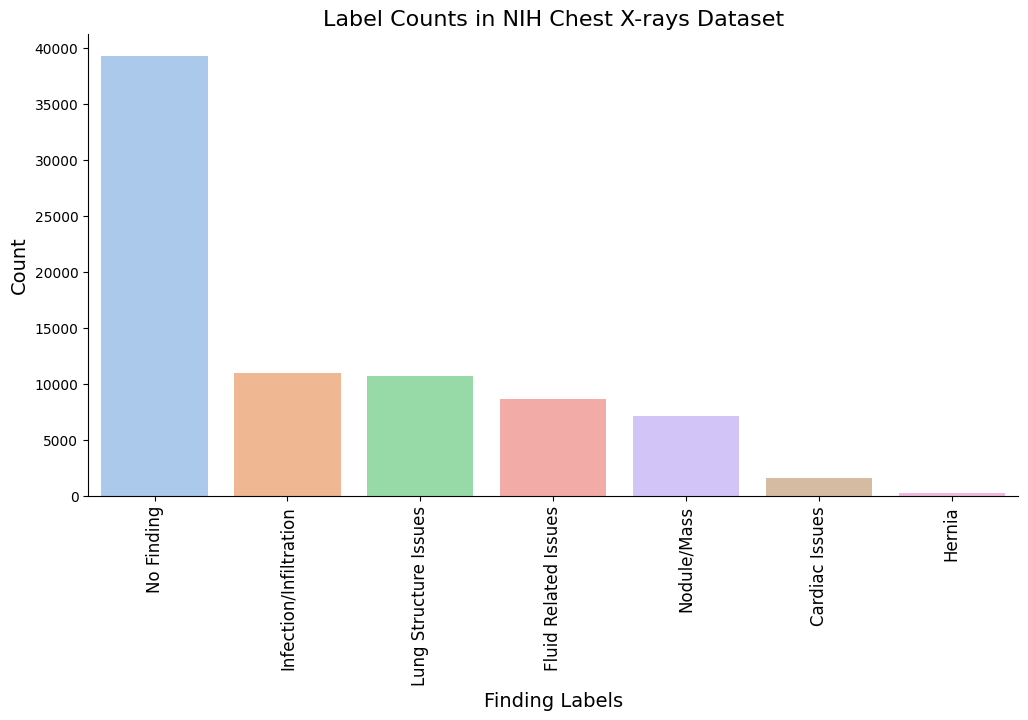

In [538]:
# Count occurrences of each label
label_counts = {label: sum(df['Finding Labels'].str.contains(label)) for label in all_labels}

# Convert to DataFrame for plotting
label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
label_counts_df = label_counts_df.sort_values(by='Count', ascending=False)

# Define a pastel color palette
palette = sns.color_palette("pastel", len(label_counts_df))

# Plot bar chart using pastel colors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Label', y='Count', data=label_counts_df, palette=palette)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=12)
plt.xlabel('Finding Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Label Counts in NIH Chest X-rays Dataset', fontsize=16)

# Remove unnecessary borders
sns.despine()


In [539]:
display(label_counts_df)

,Label,Count
6,No Finding,39302
4,Infection/Infiltration,10936
5,Lung Structure Issues,10683
2,Fluid Related Issues,8598
3,Nodule/Mass,7140
1,Cardiac Issues,1563
0,Hernia,192


<ipython-input-540-f52b0187c395>:23: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.barplot(


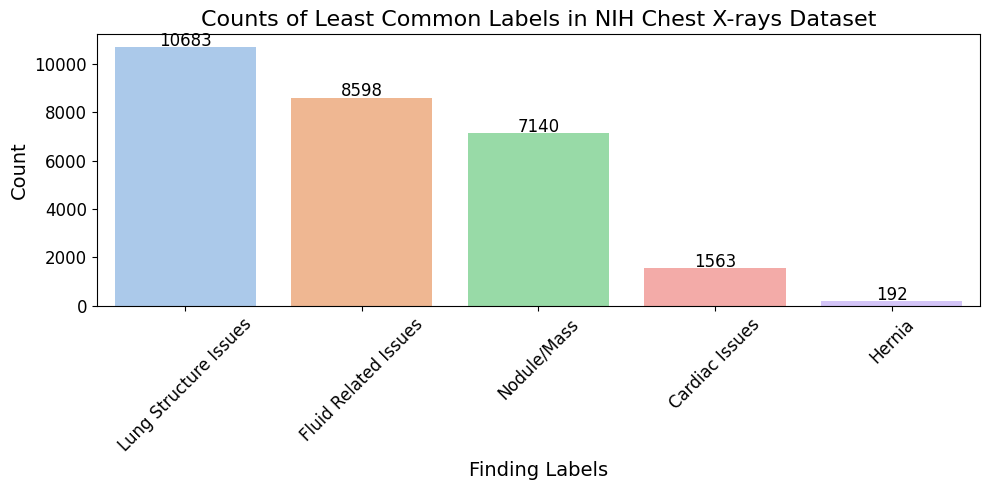

<Figure size 640x480 with 0 Axes>

Number of entries that contain at least one of the five least common labels: 22003


In [540]:
# Count occurrences of each label
label_counts = {label: sum(df['Finding Labels'].str.contains(label)) for label in all_labels}

# Convert to DataFrame and sort by count
label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Label', 'Count'])
label_counts_df = label_counts_df.sort_values(by='Count', ascending=False)

# Extract the 5 least common labels
least_common_labels_df = label_counts_df.tail(5)

# Count occurrences for these labels in the dataset
least_common_entries = df[df['Finding Labels'].apply(lambda x: any(label in x for label in least_common_labels_df['Label']))]

# Count the occurrences of these specific labels in the dataset
least_common_label_counts = {label: sum(df['Finding Labels'].str.contains(label)) for label in least_common_labels_df['Label']}

# Convert to DataFrame
least_common_label_counts_df = pd.DataFrame(list(least_common_label_counts.items()), columns=['Label', 'Count'])
palette = sns.color_palette("pastel")

# Create a bar plot with a custom color scheme
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x='Label',
    y='Count',
    hue='Label',  # Assign hue to avoid warning
    data=least_common_label_counts_df,
    palette=palette,
    legend=False  # Remove unnecessary legend
)

# Add count labels above bars
for index, row in least_common_label_counts_df.iterrows():
    ax.text(index, row['Count'] + 50, str(row['Count']), color='black', ha="center", fontsize=12)

# Customize plot aesthetics
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Finding Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Counts of Least Common Labels in NIH Chest X-rays Dataset', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

# Remove top and right border for a cleaner look
sns.despine()

# Show the plot
plt.show()

# Display the number of entries that contain the least common labels
least_common_entries_count = least_common_entries.shape[0]
print(f"Number of entries that contain at least one of the five least common labels: {least_common_entries_count}")


## Notes

* The class with lowest number of entries contains 192 images. Since it will be hard to generate synthetic data, reducing all classes to 192 images to address class imbalance will significatly reduce available data.


We can consider the following strategies for addressing the class imbalances.

1. Data Augmentation (For Underrepresented Classes)

✅ Best for Image Data

To increase the number of images in underrepresented classes, we can apply data augmentation techniques such as:

  * Geometric Transformations: Rotation, flipping, cropping, translation, scaling.
  * Color Variations: Adjust brightness, contrast, saturation.
  * Noise Injection: Adding Gaussian noise or slight blur.
  * Generative Models: Use GANs (Generative Adversarial Networks) or Diffusion Models to synthesize realistic chest X-ray images.

2. Class Weighting in Model Training

✅ Best for Training Deep Learning Models

Instead of balancing data at the dataset level, we can adjust the model's loss function to give higher weight to underrepresented classes.

3. Oversampling the Minority Classes

✅ Best when Augmentation is not feasible

Instead of generating new synthetic data, we can duplicate existing samples in the underrepresented classes.

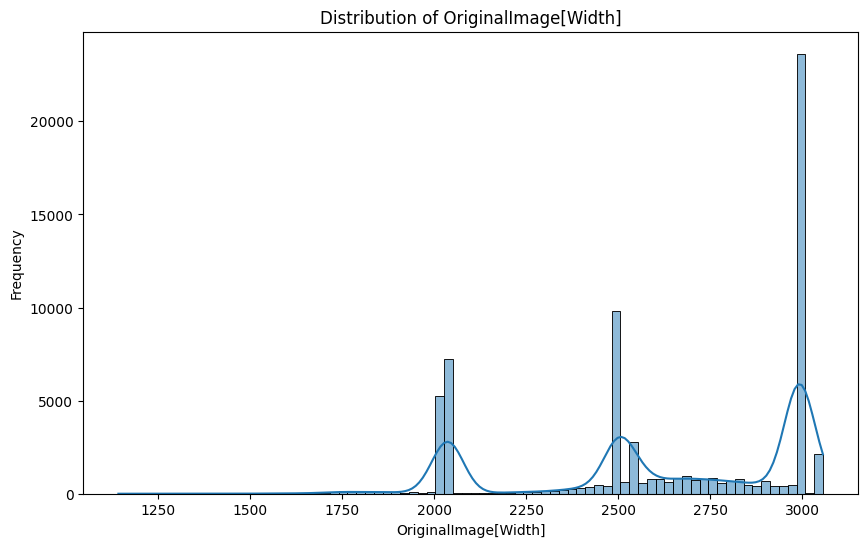

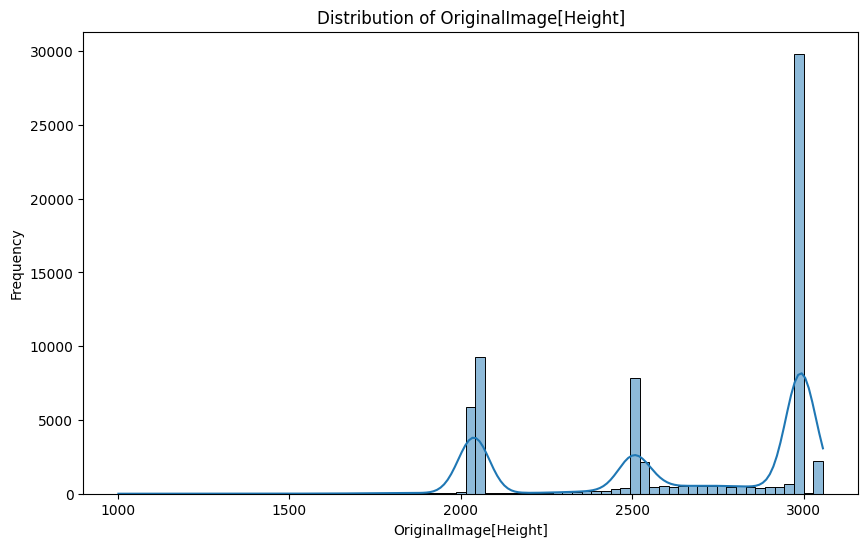

In [541]:
# Plot the distribution of OriginalImage[Width]
plt.figure(figsize=(10, 6))
sns.histplot(df['OriginalImage[Width'], kde=True)
plt.title('Distribution of OriginalImage[Width]')
plt.xlabel('OriginalImage[Width]')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of OriginalImage[Height]
plt.figure(figsize=(10, 6))
sns.histplot(df['Height]'], kde=True)
plt.title('Distribution of OriginalImage[Height]')
plt.xlabel('OriginalImage[Height]')
plt.ylabel('Frequency')
plt.show()

## Correlation Matrix

,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,has_Hernia,has_Cardiac Issues,has_Fluid Related Issues,has_Nodule/Mass,has_Infection/Infiltration,has_Lung Structure Issues,has_No Finding
0,0,1,58,M,PA,False,True,False,False,False,False,False
1,1,1,58,M,PA,False,True,False,False,False,True,False
2,2,1,58,M,PA,False,True,True,False,False,False,False
3,0,2,81,M,PA,False,False,False,False,False,False,True
4,0,3,81,F,PA,True,False,False,False,False,False,False


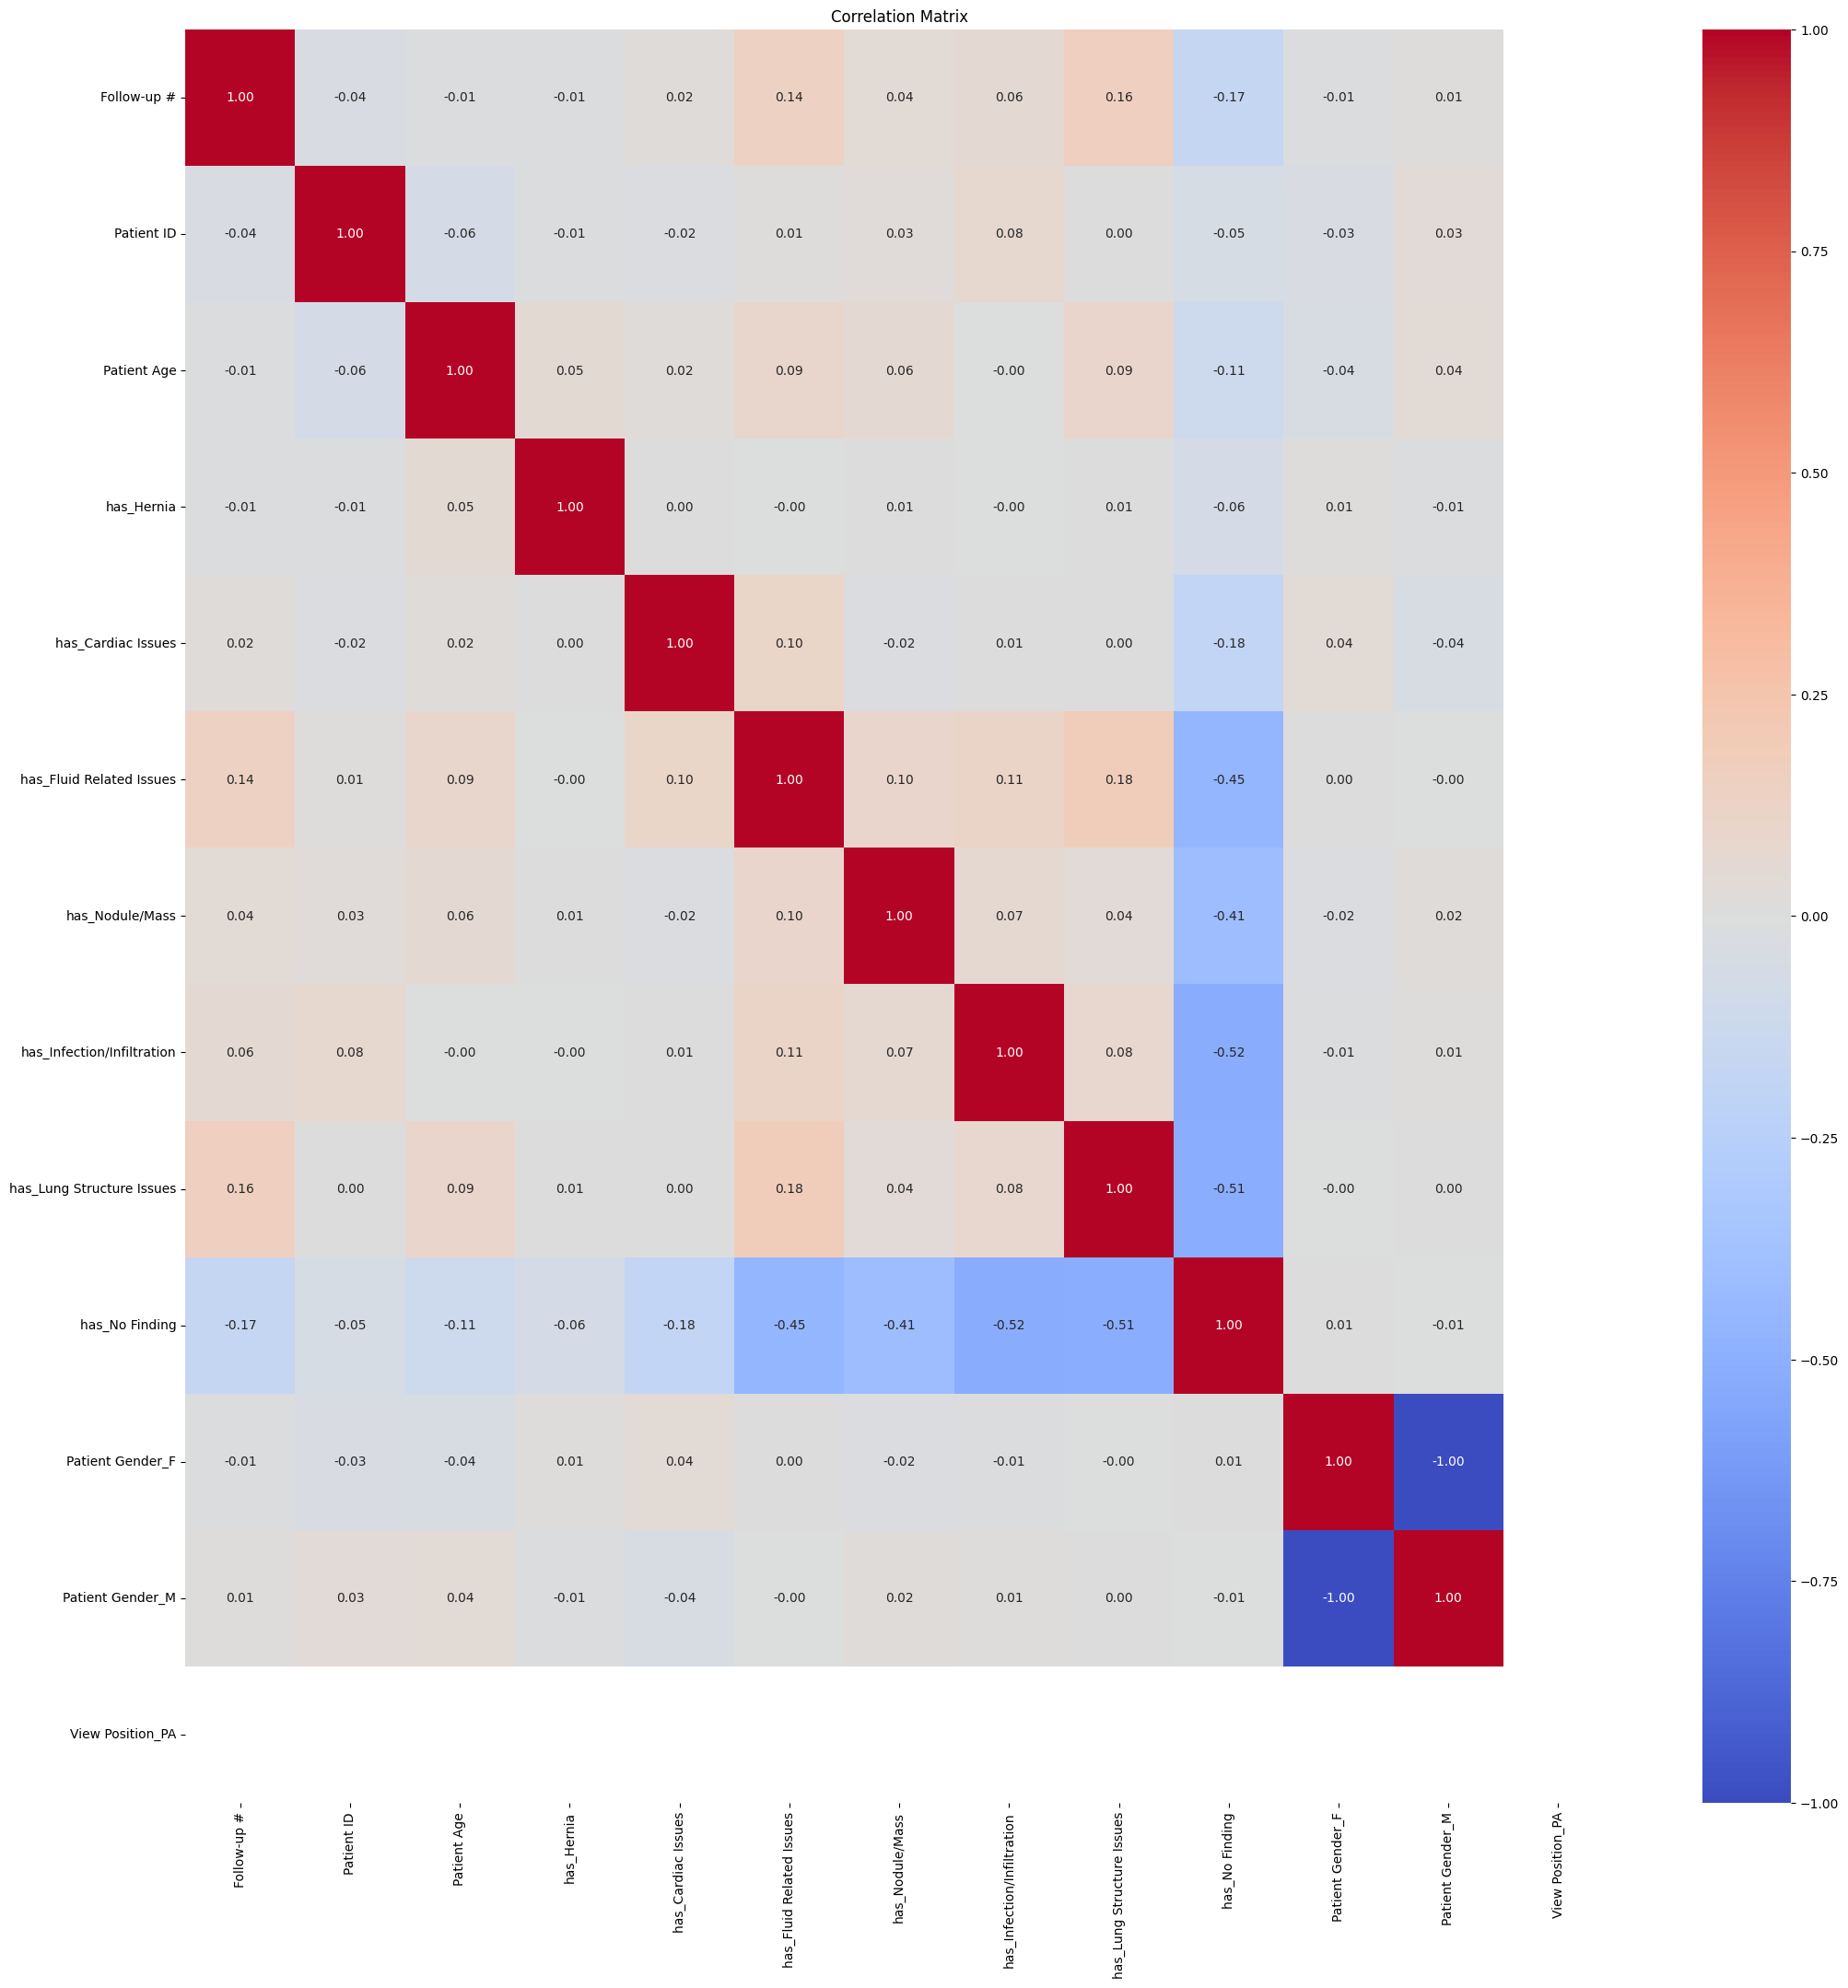

In [542]:

# Create a copy of the DataFrame to avoid modifying the original
df_processed = df.copy()

# Extract each label to a separate boolean column
for label in all_labels:
  df_processed[f'has_{label}'] = df_processed['Finding Labels'].str.contains(label)

# drop Finding Labels, Image Index, 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'
df_processed = df_processed.drop(columns=['Finding Labels', 'Image Index', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'])

display(df_processed.head())
# Encode categorical columns using one-hot encoding
categorical_columns = ['Patient Gender', 'View Position']
for column in categorical_columns:
  df_processed = pd.get_dummies(df_processed, columns=[column], prefix=[column])

# Encode the label for the boolean columns
for label in all_labels:
  df_processed[f'has_{label}'] = df_processed[f'has_{label}'].astype(int)


# Build the correlation matrix
correlation_matrix = df_processed.corr()


# Plot correlation matrix
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [543]:
display(correlation_matrix)

,Follow-up #,Patient ID,Patient Age,has_Hernia,has_Cardiac Issues,has_Fluid Related Issues,has_Nodule/Mass,has_Infection/Infiltration,has_Lung Structure Issues,has_No Finding,Patient Gender_F,Patient Gender_M,View Position_PA
Follow-up #,1.000000,-0.037928,-0.013289,-0.009183,0.018726,0.139019,0.044365,0.058027,0.161326,-0.166038,-0.009111,0.009111,NaN
Patient ID,-0.037928,1.000000,-0.063590,-0.013524,-0.019187,0.013117,0.026500,0.077087,0.004941,-0.051644,-0.033435,0.033435,NaN
Patient Age,-0.013289,-0.063590,1.000000,0.051530,0.015911,0.087079,0.055799,-0.001701,0.094682,-0.112697,-0.044918,0.044918,NaN
has_Hernia,-0.009183,-0.013524,0.051530,1.000000,0.002851,-0.001273,0.007810,-0.000902,0.006501,-0.063357,0.014536,-0.014536,NaN
has_Cardiac Issues,0.018726,-0.019187,0.015911,0.002851,1.000000,0.104129,-0.020437,0.007503,0.002681,-0.182645,0.039572,-0.039572,NaN
has_Fluid Related Issues,0.139019,0.013117,0.087079,-0.001273,0.104129,1.000000,0.100158,0.110167,0.177758,-0.453317,0.000407,-0.000407,NaN
has_Nodule/Mass,0.044365,0.026500,0.055799,0.007810,-0.020437,0.100158,1.000000,0.067088,0.038921,-0.408061,-0.019791,0.019791,NaN
has_Infection/Infiltration,0.058027,0.077087,-0.001701,-0.000902,0.007503,0.110167,0.067088,1.000000,0.079501,-0.521742,-0.012901,0.012901,NaN
has_Lung Structure Issues,0.161326,0.004941,0.094682,0.006501,0.002681,0.177758,0.038921,0.079501,1.000000,-0.514519,-0.002363,0.002363,NaN
has_No Finding,-0.166038,-0.051644,-0.112697,-0.063357,-0.182645,-0.453317,-0.408061,-0.521742,-0.514519,1.000000,0.005735,-0.005735,NaN


## Additional Charts and EDA

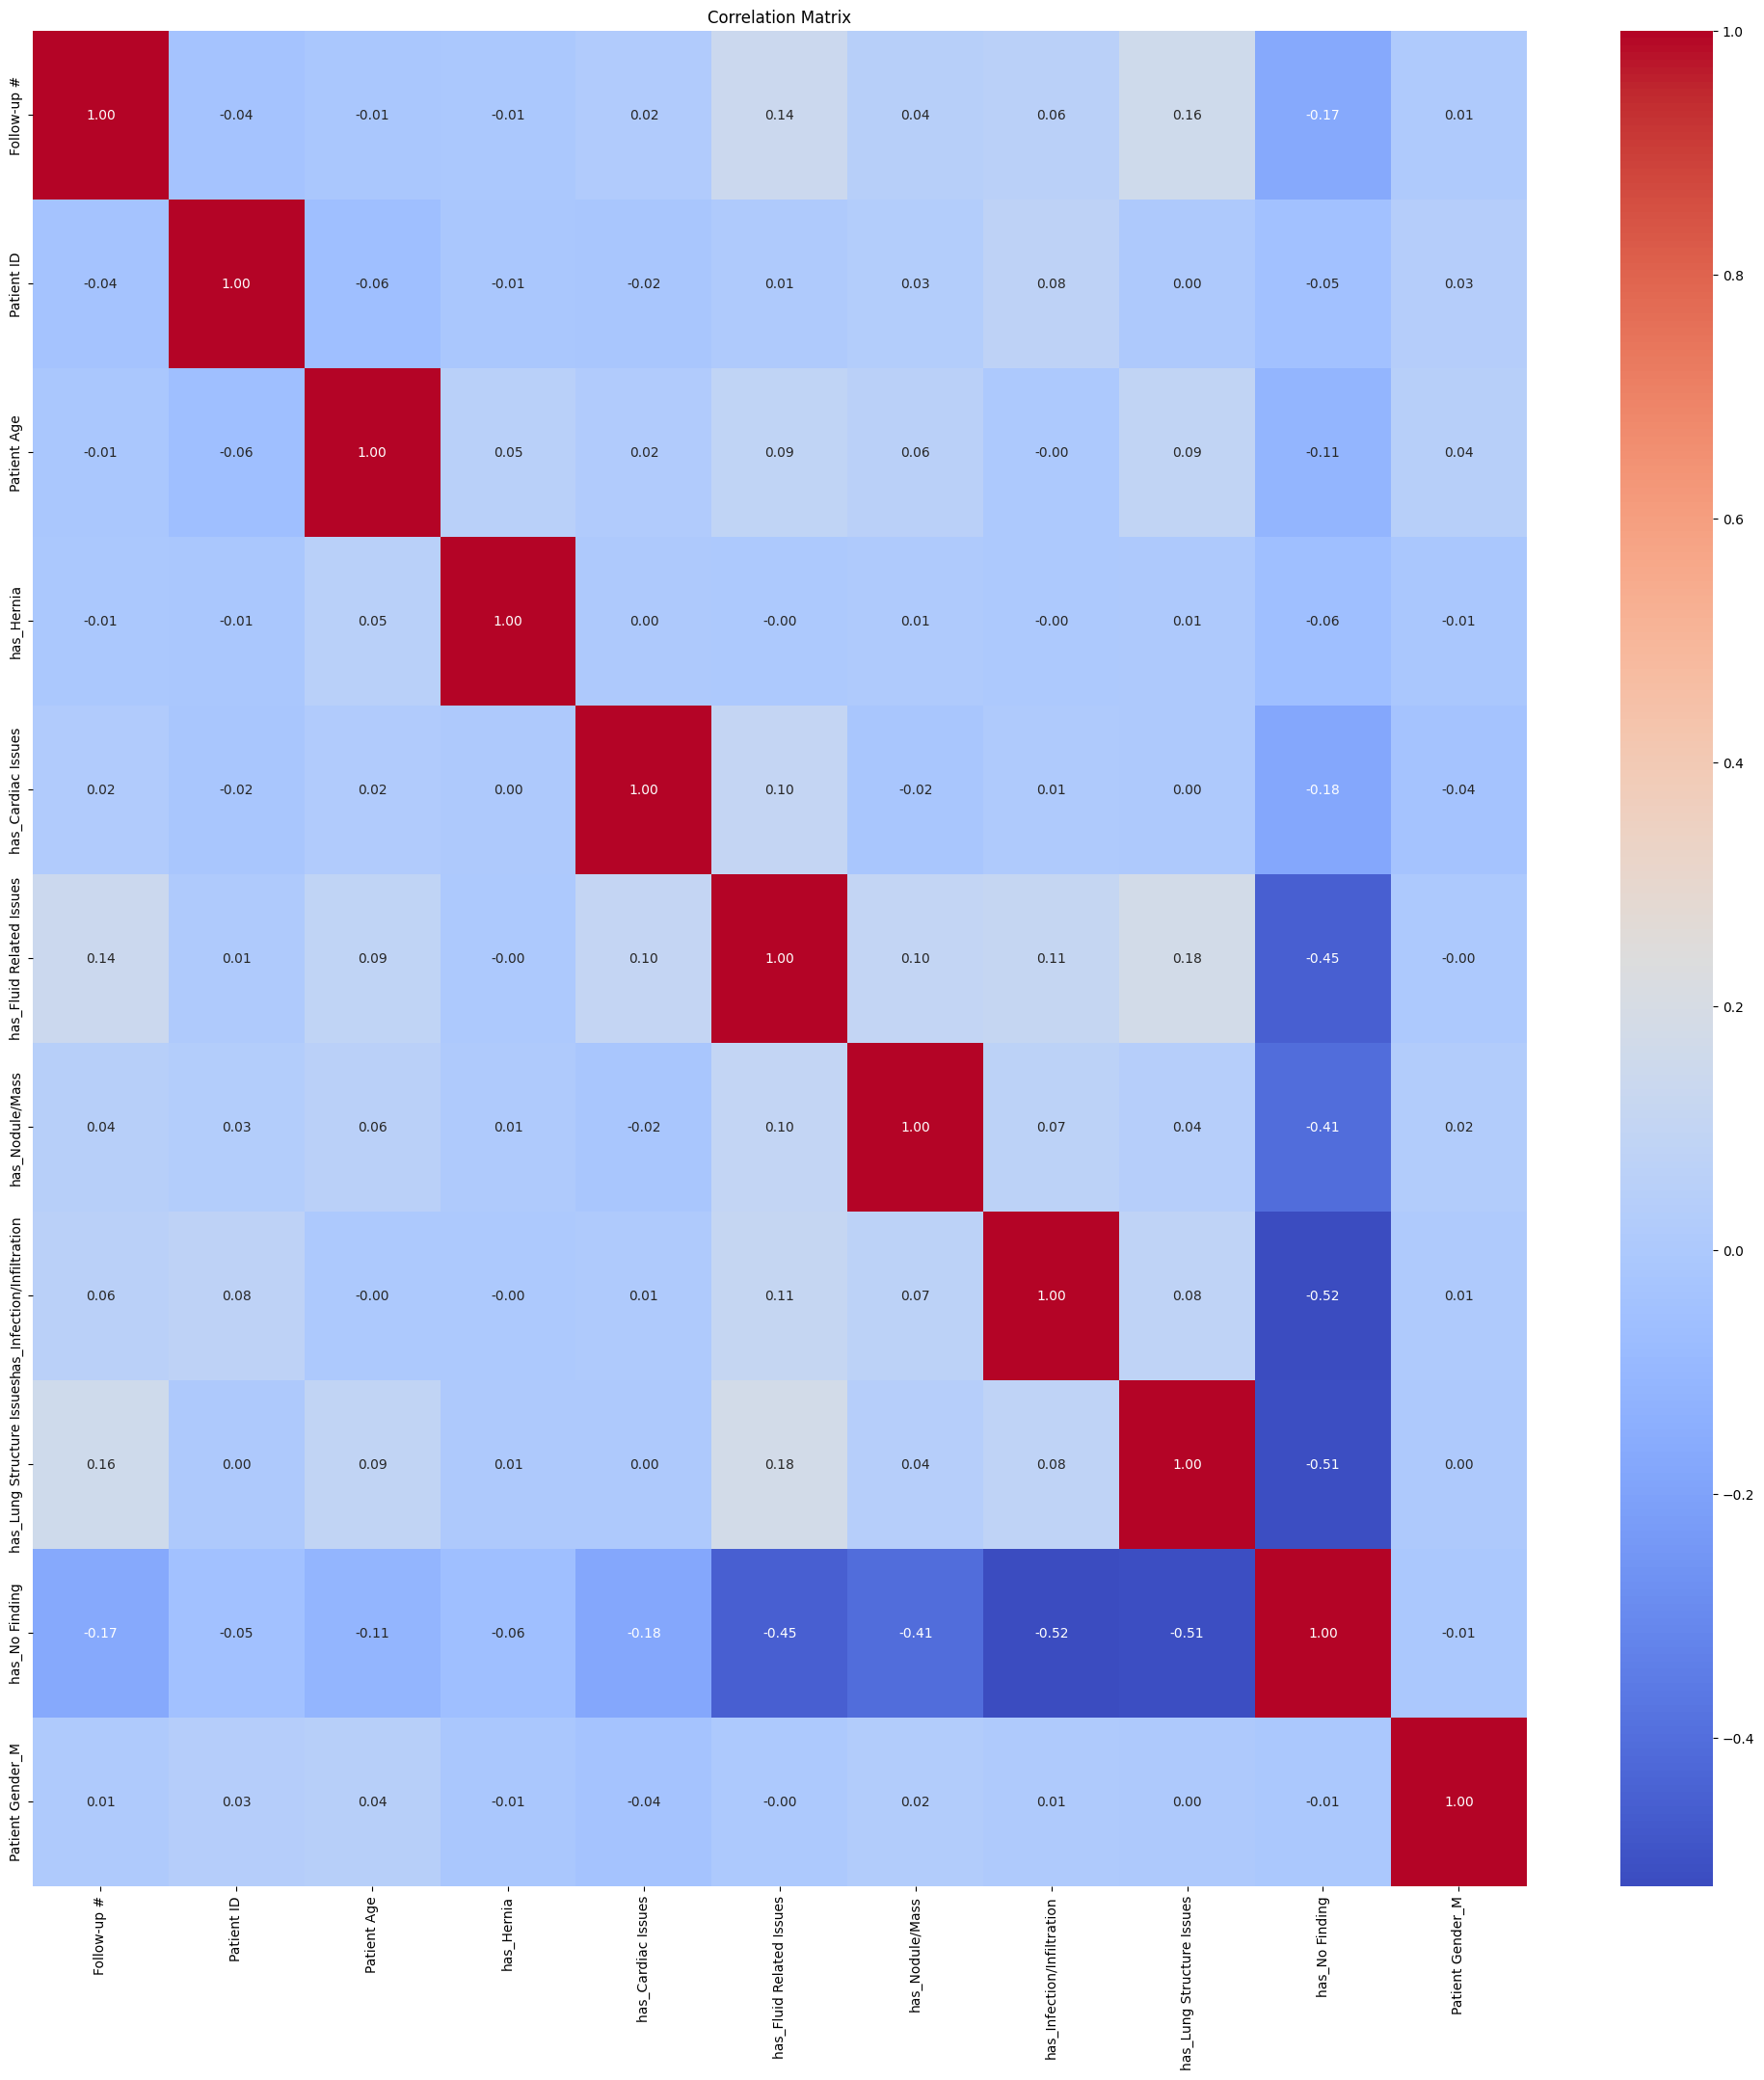

In [544]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy of the DataFrame to avoid modifying the original
df_processed = df.copy()

# Extract each label to a separate boolean column
for label in all_labels:
    df_processed[f'has_{label}'] = df_processed['Finding Labels'].fillna('').str.contains(label, regex=False).astype(int)


# Drop unnecessary columns
drop_columns = ['Finding Labels', 'Image Index', 'OriginalImage[Width', 'Height]',
                'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
df_processed = df_processed.drop(columns=drop_columns, errors='ignore')

# Encode categorical columns using one-hot encoding, dropping first category to avoid redundancy
categorical_columns = ['Patient Gender', 'View Position']
df_processed = pd.get_dummies(df_processed, columns=categorical_columns, drop_first=True)

# Build the correlation matrix
correlation_matrix = df_processed.corr()

# Plot correlation matrix
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

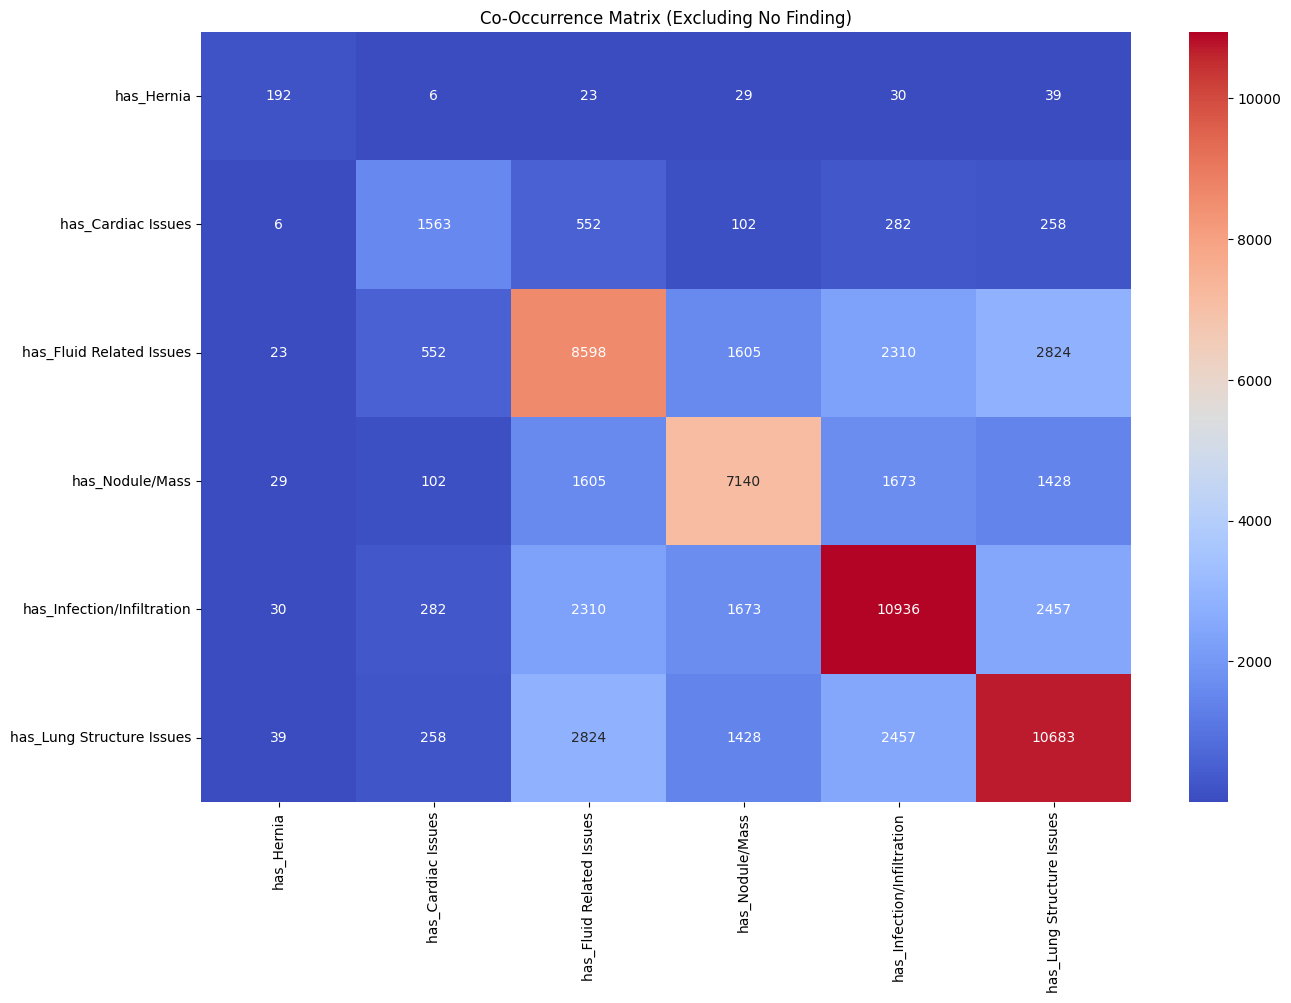

In [545]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract disease label columns, excluding 'No Finding'
disease_columns = [col for col in df_processed.columns if col.startswith('has_') and col != 'has_No Finding']

# Compute the co-occurrence matrix for the remaining disease labels
co_occurrence_matrix = np.dot(df_processed[disease_columns].T, df_processed[disease_columns])

# Convert to a DataFrame for easier visualization
co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=disease_columns, columns=disease_columns)

# Plot the co-occurrence heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(co_occurrence_df, annot=True, fmt=".0f", cmap="coolwarm")
plt.title('Co-Occurrence Matrix (Excluding No Finding)')
plt.show()


### Preview Annotated Image

In [546]:
first_image = df_box_list.iloc[0]
image_info = df_box_list[df_box_list['Image Index'] == first_image['Image Index']]

display(image_info)

# Define image file name
image_name = first_image['Image Index']

# Determine the folder using dictionary lookup
image_folder = get_image_folder(df_locked, image_name)
folder_number = int(image_folder.split("_")[1])

display(f"Image Name: {image_name}")
display(image_folder)
display(folder_number)

if SKIP_BOUNDING_BOX == False:
  urllib.request.urlretrieve(links[folder_number - 1], f"{image_folder}.tar.gz")  # download the zip file

,Image Index,Finding Label,x,y,w,h,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN


'Image Name: 00013118_008.png'

'images_006'

6

In [547]:
if SKIP_BOUNDING_BOX == False:
  !tar -xvzf images_006.tar.gz

In [548]:
# Construct the image file path
image_file = f"images/{image_name}"

if SKIP_BOUNDING_BOX == False:
  try:
    image = cv2.imread(image_file)
    if image is None:
        print(f"Error: Could not read image file '{image_file}'")
    else:
        image_info = df_box_list[df_box_list['Image Index'] == image_name]
        display(image_info.columns)

        # Extract bounding box values as integers
        x = int(image_info['x'].iloc[0])
        y = int(image_info['y'].iloc[0])
        w = int(image_info['w'].iloc[0])
        h = int(image_info['h'].iloc[0])

        # Draw the bounding box on the image
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 4)

        # Convert BGR to RGB for displaying
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Bounding Box on {image_name}")
        plt.axis("off")
        plt.show()
  except Exception as e:
      print(f"An error occurred: {e}")


## Pre-processing - Image Scaling

In [549]:
# Reduce rows with 'No Finding' label to a maximum of 10,000
no_finding_df = df[df['Finding Labels'] == 'No Finding']
if len(no_finding_df) > 10000:
    no_finding_df = no_finding_df.sample(n=10000, random_state=42)  # Randomly sample 10,000 rows

# Concatenate the reduced 'No Finding' rows with other rows
other_findings_df = df[df['Finding Labels'] != 'No Finding']
df = pd.concat([no_finding_df, other_findings_df], ignore_index=True)


In [550]:
len(df)

38008

In [551]:
# Rename columns
df = df.rename(columns={
    "OriginalImage[Width": "width",
    "Height]": "height",
    "OriginalImagePixelSpacing[x": "pixel_spacing x",
    "y]": "pixel_spacing y"
})

display(df.head())

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,pixel_spacing x,pixel_spacing y,Unnamed: 11
0,00019856_000.png,No Finding,0,19856,57,M,PA,2992,2991,0.143,0.143,NaN
1,00001020_000.png,No Finding,0,1020,52,M,PA,2500,2048,0.171,0.171,NaN
2,00008187_001.png,No Finding,1,8187,59,M,PA,2500,2048,0.168,0.168,NaN
3,00003360_003.png,No Finding,3,3360,8,M,PA,2048,2500,0.168,0.168,NaN
4,00014364_000.png,No Finding,0,14364,26,F,PA,2454,2991,0.143,0.143,NaN


In [552]:
# drop 'Unnamed: 11' column
df = df.drop(columns=['Unnamed: 11'], errors='ignore')
display(df.head())

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,pixel_spacing x,pixel_spacing y
0,00019856_000.png,No Finding,0,19856,57,M,PA,2992,2991,0.143,0.143
1,00001020_000.png,No Finding,0,1020,52,M,PA,2500,2048,0.171,0.171
2,00008187_001.png,No Finding,1,8187,59,M,PA,2500,2048,0.168,0.168
3,00003360_003.png,No Finding,3,3360,8,M,PA,2048,2500,0.168,0.168
4,00014364_000.png,No Finding,0,14364,26,F,PA,2454,2991,0.143,0.143


In [553]:
import os
import tarfile
import urllib.request

def download_and_extract(links, folder_ranges, df_locked):
    """Downloads image archives, extracts them, and organizes images."""

    if not os.path.exists("images"):
        os.makedirs("images")

    for i, link in enumerate(links):
        folder_name = f"images_{i+1:03d}"
        archive_name = f"{folder_name}.tar.gz"

        if not os.path.exists(os.path.join("images", archive_name)): #check if the archive already exists to prevent unnecessary downloads
          print(f"Downloading {archive_name}...")
          urllib.request.urlretrieve(link, archive_name)
        else:
          print(f"Skipping download for {archive_name} as file already exists")


        try:
            print(f"Extracting {archive_name}...")
            with tarfile.open(archive_name, "r:gz") as tar:
                tar.extractall()
            print("Extraction complete.")
        except Exception as e:
            print(f"Error extracting {archive_name}: {e}")
            continue  # Skip to the next archive if extraction fails

        # Move extracted images to the 'images' folder
        source_folder = folder_name
        if os.path.exists(source_folder):
          extracted_files = os.listdir(source_folder)
          for file in extracted_files:
            source_file = os.path.join(source_folder, file)
            destination_file = os.path.join("images", file)
            try:
              os.rename(source_file, destination_file)
            except FileExistsError:
              print(f"File {file} already exists in images folder, skipping")

          os.rmdir(source_folder)
        else:
          print(f"Folder {source_folder} doesn't exist")


        # Remove the archive file
        try:
            os.remove(archive_name)
            print(f"Removed {archive_name}")
        except OSError as e:
            print(f"Error removing {archive_name}: {e}")

if SKIP_DOWNLOAD == False:
  download_and_extract(links, folder_ranges, df_locked)

In [554]:
if SKIP_DOWNLOAD == False:
  image_folder = 'images'
  num_images = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
  print(f"Number of images in '{image_folder}' folder: {num_images}")

In [555]:
if SKIP_DOWNLOAD == False:
  image_folder = 'images'

  # Get a set of image names from the 'Image Index' column of the DataFrame
  image_names_in_df = set(df['Image Index'].unique())

  print(len(image_names_in_df))

  # Iterate through all files in the image folder
  for filename in os.listdir(image_folder):
      filepath = os.path.join(image_folder, filename)

      # Check if it's a file and not in the DataFrame's 'Image Index' column
      if os.path.isfile(filepath) and filename not in image_names_in_df:
          try:
              os.remove(filepath)
              print(f"Removed file: {filename}")
          except OSError as e:
              print(f"Error deleting file {filename}: {e}")


In [556]:
image_folder = 'images'
def get_num_images(image_folder):
  num_images = len([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])
  return num_images

if SKIP_DOWNLOAD == False:
  print(f"Number of images in '{image_folder}' folder: {get_num_images(image_folder)}")

In [557]:
if SKIP_DOWNLOAD == False:
  !python image_scale.py

In [558]:
if SKIP_DOWNLOAD == False:
  !zip -r images_resized.zip images_resized

In [559]:
if SKIP_DOWNLOAD == False:
  print(f"Number of images in 'images_resized' folder: {get_num_images('images_resized')}")

In [560]:
def zip_folder(folder_path, zip_filename):
  """Zips a folder.
  Args:
    folder_path: The path to the folder to zip.
    zip_filename: The name of the zip file to create.
  """

  # Create a zip archive
  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(folder_path):
      for file in files:
        zipf.write(os.path.join(root, file),
                   os.path.relpath(os.path.join(root, file),
                                   os.path.join(folder_path, '..')))
if SKIP_DOWNLOAD == False:
  zip_folder('images_resized', 'images_resized.zip')

In [561]:
if SKIP_DOWNLOAD == False:
  !cp images_resized.zip "{RESIZED_IMAGES_ZIP_PATH}}"

In [562]:
import zipfile

if SKIP_UNZIP == False:
    # Download the file from Google Drive
    !cp "{RESIZED_IMAGES_ZIP_PATH}" "/content/images_resized.zip"

    # Extract the zip file
    with zipfile.ZipFile("/content/images_resized.zip", 'r') as zip_ref:
        zip_ref.extractall("/content/image_resized")

    print("File downloaded and extracted successfully.")

### Multi-label encoding

In [563]:
# Extract all unique labels
all_labels = sorted(set(label for sublist in df['Finding Labels'].str.split('|') for label in sublist))
display(all_labels)

# Encode multi-labels
def encode_multilabel(labels):
    label_set = labels.split('|')
    return [1 if label in label_set else 0 for label in all_labels]

df['encoded_labels'] = df['Finding Labels'].apply(encode_multilabel)
display(df.head())

y = np.array(df['encoded_labels'].tolist())

['Cardiac Issues',
 'Fluid Related Issues',
 'Hernia',
 'Infection/Infiltration',
 'Lung Structure Issues',
 'No Finding',
 'Nodule/Mass']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,pixel_spacing x,pixel_spacing y,encoded_labels
0,00019856_000.png,No Finding,0,19856,57,M,PA,2992,2991,0.143,0.143,"[0, 0, 0, 0, 0, 1, 0]"
1,00001020_000.png,No Finding,0,1020,52,M,PA,2500,2048,0.171,0.171,"[0, 0, 0, 0, 0, 1, 0]"
2,00008187_001.png,No Finding,1,8187,59,M,PA,2500,2048,0.168,0.168,"[0, 0, 0, 0, 0, 1, 0]"
3,00003360_003.png,No Finding,3,3360,8,M,PA,2048,2500,0.168,0.168,"[0, 0, 0, 0, 0, 1, 0]"
4,00014364_000.png,No Finding,0,14364,26,F,PA,2454,2991,0.143,0.143,"[0, 0, 0, 0, 0, 1, 0]"


### Encode Tabular Labels

In [564]:
# Encode gender (e.g., Male/Female -> 0/1)
df['Patient Gender'] = LabelEncoder().fit_transform(df['Patient Gender'])

# Standardize numerical features
scaler = StandardScaler()
df['Patient Age'] = scaler.fit_transform(df[['Patient Age']])
df['Follow-up #'] = scaler.fit_transform(df[['Follow-up #']])

display(df.head())

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,width,height,pixel_spacing x,pixel_spacing y,encoded_labels
0,00019856_000.png,No Finding,-0.552742,19856,0.525833,1,PA,2992,2991,0.143,0.143,"[0, 0, 0, 0, 0, 1, 0]"
1,00001020_000.png,No Finding,-0.552742,1020,0.215450,1,PA,2500,2048,0.171,0.171,"[0, 0, 0, 0, 0, 1, 0]"
2,00008187_001.png,No Finding,-0.457542,8187,0.649986,1,PA,2500,2048,0.168,0.168,"[0, 0, 0, 0, 0, 1, 0]"
3,00003360_003.png,No Finding,-0.267142,3360,-2.515918,1,PA,2048,2500,0.168,0.168,"[0, 0, 0, 0, 0, 1, 0]"
4,00014364_000.png,No Finding,-0.552742,14364,-1.398540,0,PA,2454,2991,0.143,0.143,"[0, 0, 0, 0, 0, 1, 0]"


 ### Train/Test Split

In [565]:
# Create a copy of the DataFrame
df_processed = df.copy()

# Drop unnecessary columns
columns_to_drop = ['Finding Labels', 'width', 'height', 'pixel_spacing x', 'pixel_spacing y', 'View Position']
df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')

# Perform train/validation split
train_df, val_df = train_test_split(df_processed, test_size=0.2, random_state=42)
print("Train size:", len(train_df))
print("Val size:", len(val_df))

display(train_df.head())

Train size: 30406
Val size: 7602


,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,encoded_labels
2855,00015255_013.png,0.684857,15255,-0.157009,1,"[0, 0, 0, 0, 0, 1, 0]"
6626,00008663_002.png,-0.362342,8663,-0.467392,0,"[0, 0, 0, 0, 0, 1, 0]"
12335,00002471_001.png,-0.457542,2471,-0.157009,1,"[0, 1, 0, 1, 1, 0, 0]"
11355,00001397_002.png,-0.362342,1397,0.339603,1,"[0, 1, 0, 0, 0, 0, 0]"
30189,00020495_000.png,-0.552742,20495,0.153374,0,"[0, 0, 0, 1, 0, 0, 0]"


### Address Class Imbalance

In [566]:
# Flatten all labels into one array for each class
class_weights = {}
for i, label in enumerate(all_labels):
    label_values = y[:, i]
    class_weights[i] = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=label_values)[1]  # 1 = positive class, classes is now a NumPy array

print(class_weights)

{0: np.float64(12.15866922584773), 1: np.float64(2.2102814608048384), 2: np.float64(98.97916666666667), 3: np.float64(1.7377468910021945), 4: np.float64(1.7789010577553122), 5: np.float64(1.9004), 6: np.float64(2.661624649859944)}


### Data Generator (Image + Tabular)

In [567]:
import tensorflow as tf
import os
import numpy as np

IMG_SIZE = 512  # Reduced image size
IMAGE_PATH = '/content/image_resized/images_resized'

def load_image(image_id):
    """Loads and preprocesses a single image."""
    # Convert image_id to string before joining paths
    path = os.path.join(IMAGE_PATH, image_id.numpy().decode('utf-8')) # Decodes the byte string to a regular string
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE]) # Resize the image to a fixed size
    image = image / 255.0  # Normalize pixel values
    return image

def make_dataset(df):
    """Creates a tf.data.Dataset for the given DataFrame."""
    image_paths = df['Image Index'].values
    tabular_features = df[['Follow-up #', 'Patient Age', 'Patient Gender']].values.astype(np.float32)
    labels = np.array(df['encoded_labels'].tolist()).astype(np.float32)

    # Create a tf.data.Dataset from image paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tabular_features, labels))
    # Map the load_image function to load and preprocess images on the fly
    dataset = dataset.map(lambda img_path, tab_feat, label: (tf.py_function(load_image, [img_path], tf.float32), tab_feat, label), # Use tf.py_function
                          num_parallel_calls=tf.data.AUTOTUNE)  # Use parallel calls for faster loading

    # Set the shape of the image tensor explicitly
    dataset = dataset.map(lambda image, tab_feat, label: (tf.ensure_shape(image, [IMG_SIZE, IMG_SIZE, 3]), tab_feat, label))

    # Batch and prefetch the dataset
    dataset = dataset.batch(4).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = make_dataset(train_df)
val_dataset = make_dataset(val_df)

### Build the Hybrid CNN + Tabular Model

In [569]:
def build_model(hp, img_shape=(512, 512, 3), tab_shape=(3,), num_labels=len(all_labels)):
    # Image branch
    img_input = Input(shape=img_shape, name='input_layer')
    x = layers.Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu')(img_input)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=256, step=64), (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)

    # Tabular branch
    tab_input = Input(shape=tab_shape, name='input_layer_1')
    t = layers.Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu')(tab_input)

    # Combine
    combined = layers.concatenate([x, t])
    z = layers.Dense(hp.Int('dense_units_2', min_value=64, max_value=256, step=64), activation='relu')(combined)
    z = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1))(z)
    output = layers.Dense(num_labels, activation='sigmoid')(z)

    model = Model(inputs=[img_input, tab_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


### Train the Model

In [571]:
# Custom training loop
def format_batch(batch):
    # batch is now a tuple of (image, tab, label)
    image, tab, label = batch
    return ({"input_layer": image, "input_layer_1": tab}, label)

train_ds = train_dataset.map(lambda x,y,z: format_batch((x,y,z))) # Pass all 3 elements as a single tuple to format_batch
val_ds = val_dataset.map(lambda x,y,z: format_batch((x,y,z))) # Pass all 3 elements as a single tuple to format_batch


In [ ]:
# Create a HyperModel instance
class CustomHyperModel(HyperModel):
    def build(self, hp):
        return build_model(hp)

# Set up Keras Tuner Random Search
tuner = RandomSearch(
    CustomHyperModel(),
    objective='val_accuracy',  # Optimize for validation accuracy
    max_trials=10,  # Number of random search trials
    executions_per_trial=3,  # Number of executions per trial
    directory='tuner_results',  # Directory to save results
    project_name='image_and_tabular_tuning'
)

# Train the tuner to search for the best hyperparameters
tuner.search(train_ds, validation_data=val_ds, epochs=3, class_weight=class_weights)

# Get the best model from the search
best_model = tuner.get_best_models(num_models=1)[0]

# Display the best model's summary
best_model.summary()

Reloading Tuner from tuner_results/image_and_tabular_tuning/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |32                |conv_1_filters
128               |128               |conv_2_filters
96                |64                |dense_units
64                |192               |dense_units_2
0.3               |0.3               |dropout_rate

Epoch 1/3
7602/7602 ━━━━━━━━━━━━━━━━━━━━ 234s 30ms/step - accuracy: 0.1935 - loss: 1.5929 - val_accuracy: 0.2302 - val_loss: 0.4555
Epoch 2/3
7602/7602 ━━━━━━━━━━━━━━━━━━━━ 210s 28ms/step - accuracy: 0.2228 - loss: 1.4070 - val_accuracy: 0.2193 - val_loss: 0.4596
Epoch 3/3
7602/7602 ━━━━━━━━━━━━━━━━━━━━ 210s 28ms/step - accuracy: 0.2303 - loss: 1.3948 - val_accuracy: 0.2292 - val_loss: 0.4545
Epoch 1/3


In [ ]:
# Custom training loop
def format_batch(batch):
    # batch is now a tuple of (image, tab, label)
    image, tab, label = batch
    return ({"input_layer": image, "input_layer_1": tab}, label)

train_ds = train_dataset.map(lambda x,y,z: format_batch((x,y,z))) # Pass all 3 elements as a single tuple to format_batch
val_ds = val_dataset.map(lambda x,y,z: format_batch((x,y,z))) # Pass all 3 elements as a single tuple to format_batch


model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    class_weight=class_weights
)